In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_probability as tfp

import seaborn as sns
sns.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr
import pingouin as pg
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import label_ranking_average_precision_score, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc, roc_auc_score,precision_recall_curve, hamming_loss, multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import pickle

from sklearn import feature_selection #import chi2

## for deep learning
import tensorflow_hub as hub
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
tfd = tfp.distributions

In [2]:
import sys
import os
sys.path.append('../')
from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
test_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_data','ICS_predictive_sitreps_full_test.csv')).drop(["Unnamed: 0"], axis=1)
train_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_data','ICS_predictive_sitreps_full_train.csv')).drop(["Unnamed: 0"], axis=1)
val_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_data','ICS_predictive_sitreps_full_val.csv')).drop(["Unnamed: 0"], axis=1)

In [4]:
meta_predictors = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES", "EVACUATION_IN_PROGRESS", 
              "NUM_REPORTS", "DAYS_BURING", #'Combined_Text', 
              'Incident_region_AICC', 
              'Incident_region_CA', 'Incident_region_EACC','Incident_region_GBCC', 'Incident_region_HICC', 
              'Incident_region_NRCC','Incident_region_NWCC', 'Incident_region_RMCC', 'Incident_region_SACC',
              'Incident_region_SWCC', 'INC_MGMT_ORG_ABBREV_1', 'INC_MGMT_ORG_ABBREV_2','INC_MGMT_ORG_ABBREV_3', 
              'INC_MGMT_ORG_ABBREV_4','INC_MGMT_ORG_ABBREV_5', 'INC_MGMT_ORG_ABBREV_B','INC_MGMT_ORG_ABBREV_C', 
              'INC_MGMT_ORG_ABBREV_D','INC_MGMT_ORG_ABBREV_E', 'INC_MGMT_ORG_ABBREV_F']
targets = ["Traffic","Command_Transitions","Evacuations", "Inaccurate_Mapping", "Aerial_Grounding", 
           "Resource_Issues", "Injuries", "Cultural_Resources","Livestock", "Law_Violations", "Military_Base", 
           "Infrastructure", "Extreme_Weather", "Ecological", "Hazardous_Terrain", "Floods", "Dry_Weather"]

In [5]:
predictors=meta_predictors

# Prepare the Data

In [6]:
def remove_quote_marks(word_list):
    word_list = word_list.strip("[]").split(", ")
    word_list = [w.replace("'","") for w in word_list]
    word_list = " ".join(word_list)
    return word_list

In [7]:
dfs = [train_data, val_data, test_data]
for df in dfs:
    cleaned_combined_text = []
    for text in df['Combined_Text']:
        cleaned_text = remove_quote_marks(text)
        cleaned_combined_text.append(cleaned_text)
    df['Combined_Text'] = cleaned_combined_text

In [8]:
Xtrain = train_data['Raw_Combined_Text']; ytrain = train_data[targets]
Xval = val_data['Raw_Combined_Text']; yval = val_data[targets]
Xtest = test_data['Raw_Combined_Text']; ytest = test_data[targets]

# DNN

In [9]:
NUM_TRAIN_EXAMPLES = len(Xtrain)
NUM_TRAIN_EXAMPLES

39357

In [10]:
def build_model(features, num_neurons, drop_rate=0.5, num_layers=1, reg='l2', dropout=False, LSTM=False, l1=0.01, l2=0.01, batch_norm=False, activation='tanh', p=False):
    if activation == 'tanh':
        initializer = tf.keras.initializers.GlorotNormal()
    elif activation == 'relu':
        initializer = tf.keras.initializers.HeNormal()
    USE_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name='USE_input')
    USE_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                    trainable=True)(USE_input)
    if LSTM:
        USE_layer= tf.keras.layers.Reshape((1, 512))(USE_layer)
        USE_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(USE_layer)
    else:
        USE_output = tf.keras.layers.Dense(17, activation='sigmoid')(USE_layer)
        
    meta_input = tf.keras.layers.Input(shape=(features,), name='meta_input')
    combined_USE_meta = tf.keras.layers.Concatenate()([USE_output, meta_input])
    prev_layer = combined_USE_meta
    for i in range(num_layers):
        if batch_norm == True:
            prev_layer = tf.keras.layers.BatchNormalization()(prev_layer) # after layer before activation
        
        if reg == 'l1':
            Curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l1(l1),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        elif reg =='l2':
            curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        else:
             curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        if dropout == True:
            curr_layer = tf.keras.layers.Dropout(rate=drop_rate)(curr_layer)
        prev_layer = curr_layer
    
    if p == False: output = tf.keras.layers.Dense(17, activation='sigmoid')(prev_layer)
    elif p == True:
        
        #kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
        #                    tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))
        output = tfp.layers.DenseFlipout(
          units=17,
          activation='sigmoid',
          kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
          bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
          #kernel_divergence_fn=kl_divergence_function)(prev_layer)
    model = tf.keras.Model(inputs=[USE_input , meta_input], outputs=output)
    return model


In [23]:
def build_text_model(features, num_neurons, drop_rate=0.5, num_layers=1, reg='l2', dropout=False, LSTM=False, l1=0.01, l2=0.01, batch_norm=False, activation='tanh', p=False):
    if activation == 'tanh':
        initializer = tf.keras.initializers.GlorotNormal()
    elif activation == 'relu':
        initializer = tf.keras.initializers.HeNormal()
    USE_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name='USE_input')
    USE_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                    trainable=True)(USE_input)
    if LSTM:
        USE_layer= tf.keras.layers.Reshape((1, 512))(USE_layer)
        USE_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(USE_layer)
    else:
        USE_output = tf.keras.layers.Dense(17, activation='sigmoid')(USE_layer)
        
    prev_layer = USE_output
    for i in range(num_layers):
        if batch_norm == True:
            prev_layer = tf.keras.layers.BatchNormalization()(prev_layer) # after layer before activation
        
        if reg == 'l1':
            Curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l1(l1),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        elif reg =='l2':
            curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        else:
             curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        if dropout == True:
            curr_layer = tf.keras.layers.Dropout(rate=drop_rate)(curr_layer)
        prev_layer = curr_layer
    
    if p == False: output = tf.keras.layers.Dense(17, activation='sigmoid')(prev_layer)
    elif p == True:
        
        #kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
        #                    tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))
        output = tfp.layers.DenseFlipout(
          units=17,
          activation='sigmoid',
          kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
          bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
          #kernel_divergence_fn=kl_divergence_function)(prev_layer)
    model = tf.keras.Model(inputs=[USE_input], outputs=output)
    return model


In [38]:
def build_meta_model(features, num_neurons, drop_rate=0.5, num_layers=1, reg='l2', dropout=False, LSTM=False, l1=0.01, l2=0.01, batch_norm=False, activation='tanh', p=False):
    if activation == 'tanh':
        initializer = tf.keras.initializers.GlorotNormal()
    elif activation == 'relu':
        initializer = tf.keras.initializers.HeNormal()
    meta_input = tf.keras.layers.Input(shape=(features,), name='meta_input')
    prev_layer =  meta_input
    for i in range(num_layers):
        if batch_norm == True:
            prev_layer = tf.keras.layers.BatchNormalization()(prev_layer) # after layer before activation
        
        if reg == 'l1':
            Curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l1(l1),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        elif reg =='l2':
            curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        else:
             curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        if dropout == True:
            curr_layer = tf.keras.layers.Dropout(rate=drop_rate)(curr_layer)
        prev_layer = curr_layer
    
    if p == False: output = tf.keras.layers.Dense(17, activation='sigmoid')(prev_layer)
    elif p == True:
        
        #kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
        #                    tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))
        output = tfp.layers.DenseFlipout(
          units=17,
          activation='sigmoid',
          kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
          bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
          #kernel_divergence_fn=kl_divergence_function)(prev_layer)
    model = tf.keras.Model(inputs=[ meta_input], outputs=output)
    return model


In [39]:
model = build_meta_model(features=len(predictors), num_neurons=500, num_layers=10, dropout=True, LSTM=True, reg=None,#'l2', l2=0.00001, 
                    activation='tanh', batch_norm=True, p=False)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 meta_input (InputLayer)     [(None, 34)]              0         
                                                                 
 batch_normalization_41 (Bat  (None, 34)               136       
 chNormalization)                                                
                                                                 
 dense_44 (Dense)            (None, 500)               17500     
                                                                 
 dropout_40 (Dropout)        (None, 500)               0         
                                                                 
 batch_normalization_42 (Bat  (None, 500)              2000      
 chNormalization)                                                
                                                                 
 dense_45 (Dense)            (None, 500)               2505

In [40]:
import tensorflow_addons as tfa
Hamming_loss=tfa.metrics.HammingLoss(mode='multilabel')#, threshold=0.6)

In [41]:
class_weights = {}
for c in range(len(targets)):
    class_weights[c] = ytrain.shape[0]/(2*np.count_nonzero(ytrain[targets[c]]==1))

In [42]:
mini_batch = 256
num_epochs = 10
lr = 1e-4
# First we need to define the optimizer to be used. We use Adam here with default hyper-parameters

optim = tf.keras.optimizers.Adam(learning_rate=lr)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
# We define the learning rate decay as a callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# then, we need to compile the model: this configures the model for training
model.compile(loss='categorical_crossentropy',#loss_fn,#'categorical_crossentropy',
              optimizer=optim, metrics=['accuracy',Hamming_loss])#, hamming_loss])

In [43]:
X_train = {#"USE_input": Xtrain}, 
    "meta_input": np.asarray(train_data[predictors]).astype(np.float32)}
X_test = {#"USE_input": Xtest}#, 
    "meta_input": np.asarray(test_data[predictors]).astype(np.float32)}
training = model.fit(x=X_train, y=ytrain.astype(float), batch_size=mini_batch, 
                    epochs=num_epochs, shuffle=True, verbose=0, validation_data=(X_test, ytest.astype(float)),
                    class_weight=class_weights)#, callbacks=[reduce_lr])

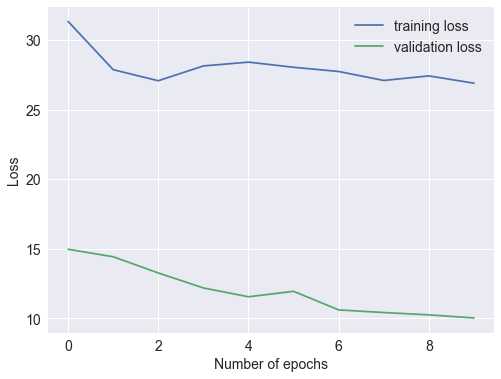

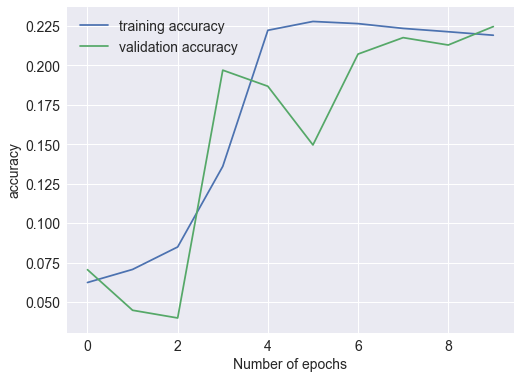

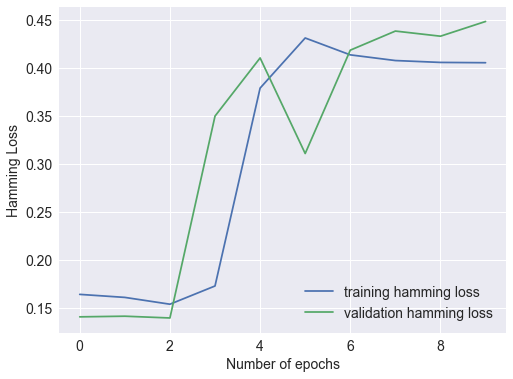

In [16]:
# plot loss and accuracy
plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['loss'], label='training loss')
plt.plot(range(num_epochs), training.history['val_loss'], label='validation loss')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('Loss', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)
plt.show()

plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['accuracy'], label='training accuracy')
plt.plot(range(num_epochs), training.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('accuracy', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)

plt.show()

plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['hamming_loss'], label='training hamming loss')
plt.plot(range(num_epochs), training.history['val_hamming_loss'], label='validation hamming loss')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('Hamming Loss', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)

plt.show()

In [17]:
test_hamming_loss = []; train_hamming_loss = []
test_acc = []; train_acc = []
test_f1 = []; train_f1 = []
test_precision = []; train_precision = []
test_recall = []; train_recall = []

In [18]:
def final_model_visuals(pred, true, targets):
    ml_cm = multilabel_confusion_matrix(true, pred)
    i=0
    for cm_ in ml_cm:
        fig, ax = plt.subplots()
        sns.heatmap(cm_, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                    cbar=False)
        ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix "+targets[i])
        plt.yticks(rotation=0)
        i+=1
    ## Plot roc
    colors = plt.cm.tab20(np.linspace(0, 1, len(targets)))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    for i in range(len(targets)):
        fpr, tpr, thresholds = roc_curve(true[:,i], pred[:,i])
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(targets[i], 
                                  auc(fpr, tpr)), color=colors[i]
                   )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(targets)):
        precision, recall, thresholds = precision_recall_curve(true[:,i], pred[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(targets[i], 
                                      auc(recall, precision)), color=colors[i]
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

In [45]:
## test
X_val = {#"USE_input": Xval}#, 
    "meta_input": np.asarray(val_data[predictors]).astype(np.float32)}
predicted_raw = model.predict(X_val)
predicted = np.around(predicted_raw)
y_val_array = yval.to_numpy()

## Accuracy, Precision, Recall
accuracy = accuracy_score(yval, predicted)
print("Hamming loss:", round(hamming_loss(yval, predicted),3))
print("Accuracy:",  round(accuracy,3))
print("Detail:")
print(classification_report(yval, predicted,zero_division=0))

predictions = np.around(model.predict(X_val))
train_preds =np.around(model.predict(X_train))
test_acc.append(round(accuracy_score(yval,predictions),3)); train_acc.append(round(accuracy_score(ytrain,train_preds),3))
test_f1.append(round(f1_score(yval,predictions, average='macro',zero_division=0),3))
train_f1.append(round(f1_score(ytrain,train_preds, average='macro',zero_division=0),3))
test_precision.append(round(precision_score(yval,predictions, average='macro', zero_division=0),3))
train_precision.append(round(precision_score(ytrain,train_preds, average='macro', zero_division=0),3))
test_recall.append(round(recall_score(yval,predictions, average='macro', zero_division=0),3))
train_recall.append(round(recall_score(ytrain,train_preds, average='macro', zero_division=0),3))
test_hamming_loss.append(round(hamming_loss(yval,predictions),3))
train_hamming_loss.append(round(hamming_loss(ytrain,train_preds),3))
## Plot confusion matrix

#final_model_visuals(predictions, yval, targets)

Hamming loss: 0.411
Accuracy: 0.342
Detail:
              precision    recall  f1-score   support

           0       0.30      0.79      0.44       874
           1       0.52      0.79      0.63      1488
           2       0.24      0.82      0.37       655
           3       0.18      0.74      0.29       567
           4       0.04      0.71      0.08       134
           5       0.24      0.81      0.37       683
           6       0.25      0.82      0.38       693
           7       0.06      0.91      0.11       141
           8       0.05      0.73      0.09       143
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          11       0.07      0.93      0.14       179
          12       0.28      0.74      0.41       869
          13       0.05      0.69      0.09       162
          14       0.57      0.78      0.66      1670
          15       0.01      0.55      0.03        62
          16       0.22      0.75    

In [46]:
comparison = pd.DataFrame({"train f1": train_f1, "test f1": test_f1,
                          "train accuracy":train_acc, "test accuracy": test_acc,
                          "train recall": train_recall, "test recall": test_recall,
                          "train precision": train_precision, "test precision": test_precision,
                          "train hamming loss": train_hamming_loss, "test hamming loss": test_hamming_loss})
comparison

,train f1,test f1,train accuracy,test accuracy,train recall,test recall,train precision,test precision,train hamming loss,test hamming loss
0,0.316,0.275,0.371,0.348,0.922,0.770,0.217,0.188,0.407,0.432
1,0.315,0.272,0.369,0.338,0.907,0.763,0.217,0.187,0.400,0.427
2,0.286,0.260,0.323,0.342,0.835,0.679,0.196,0.182,0.427,0.411


In [55]:
model.save(os.path.join(os.path.dirname(os.getcwd()),'models','USE_hazard_classification_BN_model'))

INFO:tensorflow:Assets written to: C:\Users\srandrad\smart_nlp\models\USE_hazard_classification_BN_model\assets


INFO:tensorflow:Assets written to: C:\Users\srandrad\smart_nlp\models\USE_hazard_classification_BN_model\assets


In [88]:
# model = models.load_model(os.path.join(os.path.dirname(os.getcwd()),'models','USE_hazard_classification_model'),custom_objects={'Hamming_loss':hamming_loss}, compile=False)
# model.compile()

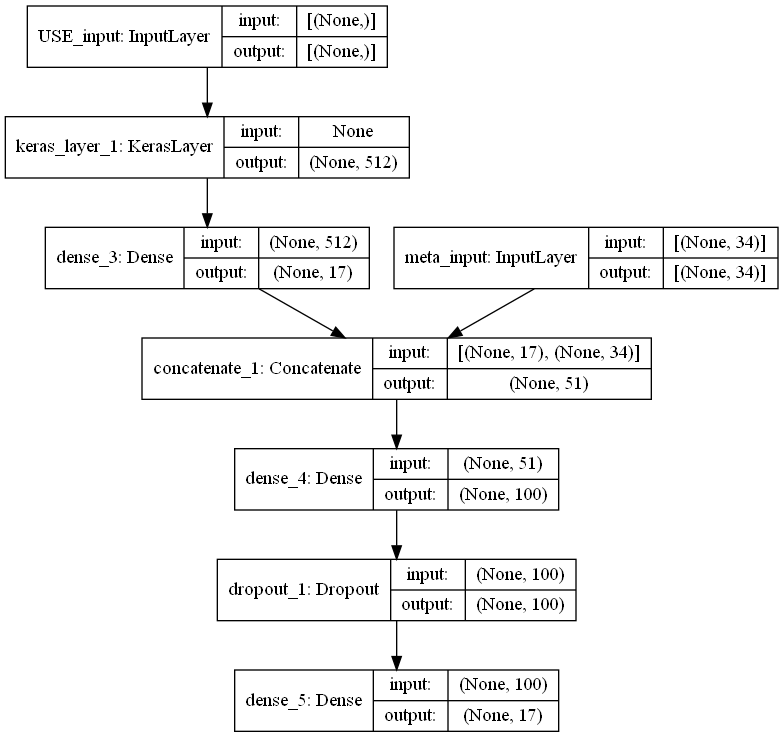

In [43]:
# filename = os.path.join(os.path.dirname(os.getcwd()),'results','hazard_classification_model.png')
# tf.keras.utils.plot_model(model, to_file=filename, show_shapes=True)